# Investigate Titanic's Data
## Questions to ask ourselves
### What factors made people more likely to survive?
* Sex
* Class
* Age
* How much they paid

In [28]:
#imports
import pandas as pd
import numpy as np

In [22]:
raw_data = pd.read_csv('titanic_data.csv')

In [26]:
raw_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


## Data Wrangling
We need to find the amount of nulls that our data has.

`describe` function might be useful

In [9]:
raw_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


we realise however that in this way we are not able to see NA in non-numeric columns.

We move to another option:

In [12]:
raw_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### How do we treat nulls
#### In AGE
Out of 891 rows, we have 177 *NaN*, which represent roughly a 20%. If we replace this NaN with some other value we should be guard value, so it does not affect the rest of the values. 

### In Cabin
Out of 891 rows, 687 are nulls, representing an astounding 77%. **Ignoring this column** altogether makes more sense.

### In Embarked
Only 2 NaN in this column make it possible to simply **ignore this rows**. We could also decide another value and see how they behave.

### Code
#### Age

In [24]:
clean_data = raw_data.copy()
clean_data['Age'] = clean_data['Age'].fillna(-1)

#### Cabin

In [25]:
clean_data.drop('Cabin', axis=1, inplace=True)

#### Embarked
Before deleting anything, let's check the rows

In [27]:
raw_data[raw_data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,NaN


It looks a bit strange that they both survived, are in the same Cabin and we lack their Embarked information, using the same ticket.

Instead of deleting them we will leave the rows for now.

In [34]:
%pylab inline
figsize(47,20)

Populating the interactive namespace from numpy and matplotlib


## Data Exploration
We want to be able to see all this data depicted in this ways:
* How many people survived?
* Survival by age
* Survival by sex
* Survival by age and sex
* Survival by age and class
* Survival by sex and class

To be able to see where the survival rates are most gathered.
### How many people survived?
As a first data exploration trade we are interested first, in how many people survived.

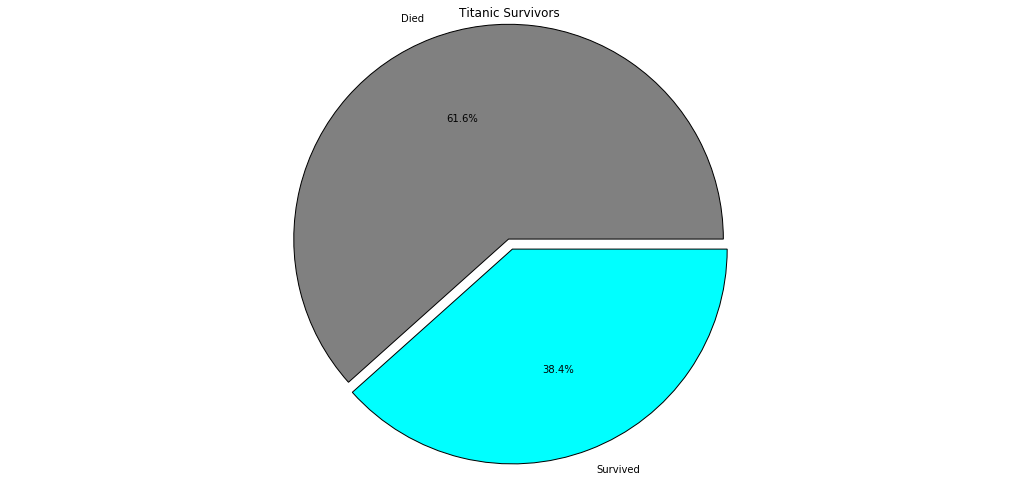

In [79]:
import matplotlib.pyplot as plt
survivors = clean_data.groupby('Survived').count()['Name']

plt.figure(figsize=(18,8))
cmap = plt.cm.hsv
colors = ['grey','cyan']
plt.pie(survivors, labels=['Died','Survived'], explode=[0,0.05], autopct='%1.1f%%', colors = colors)

plt.axis("equal")
plt.title("Titanic Survivors")
plt.show();

### Survival by Age
#### Code

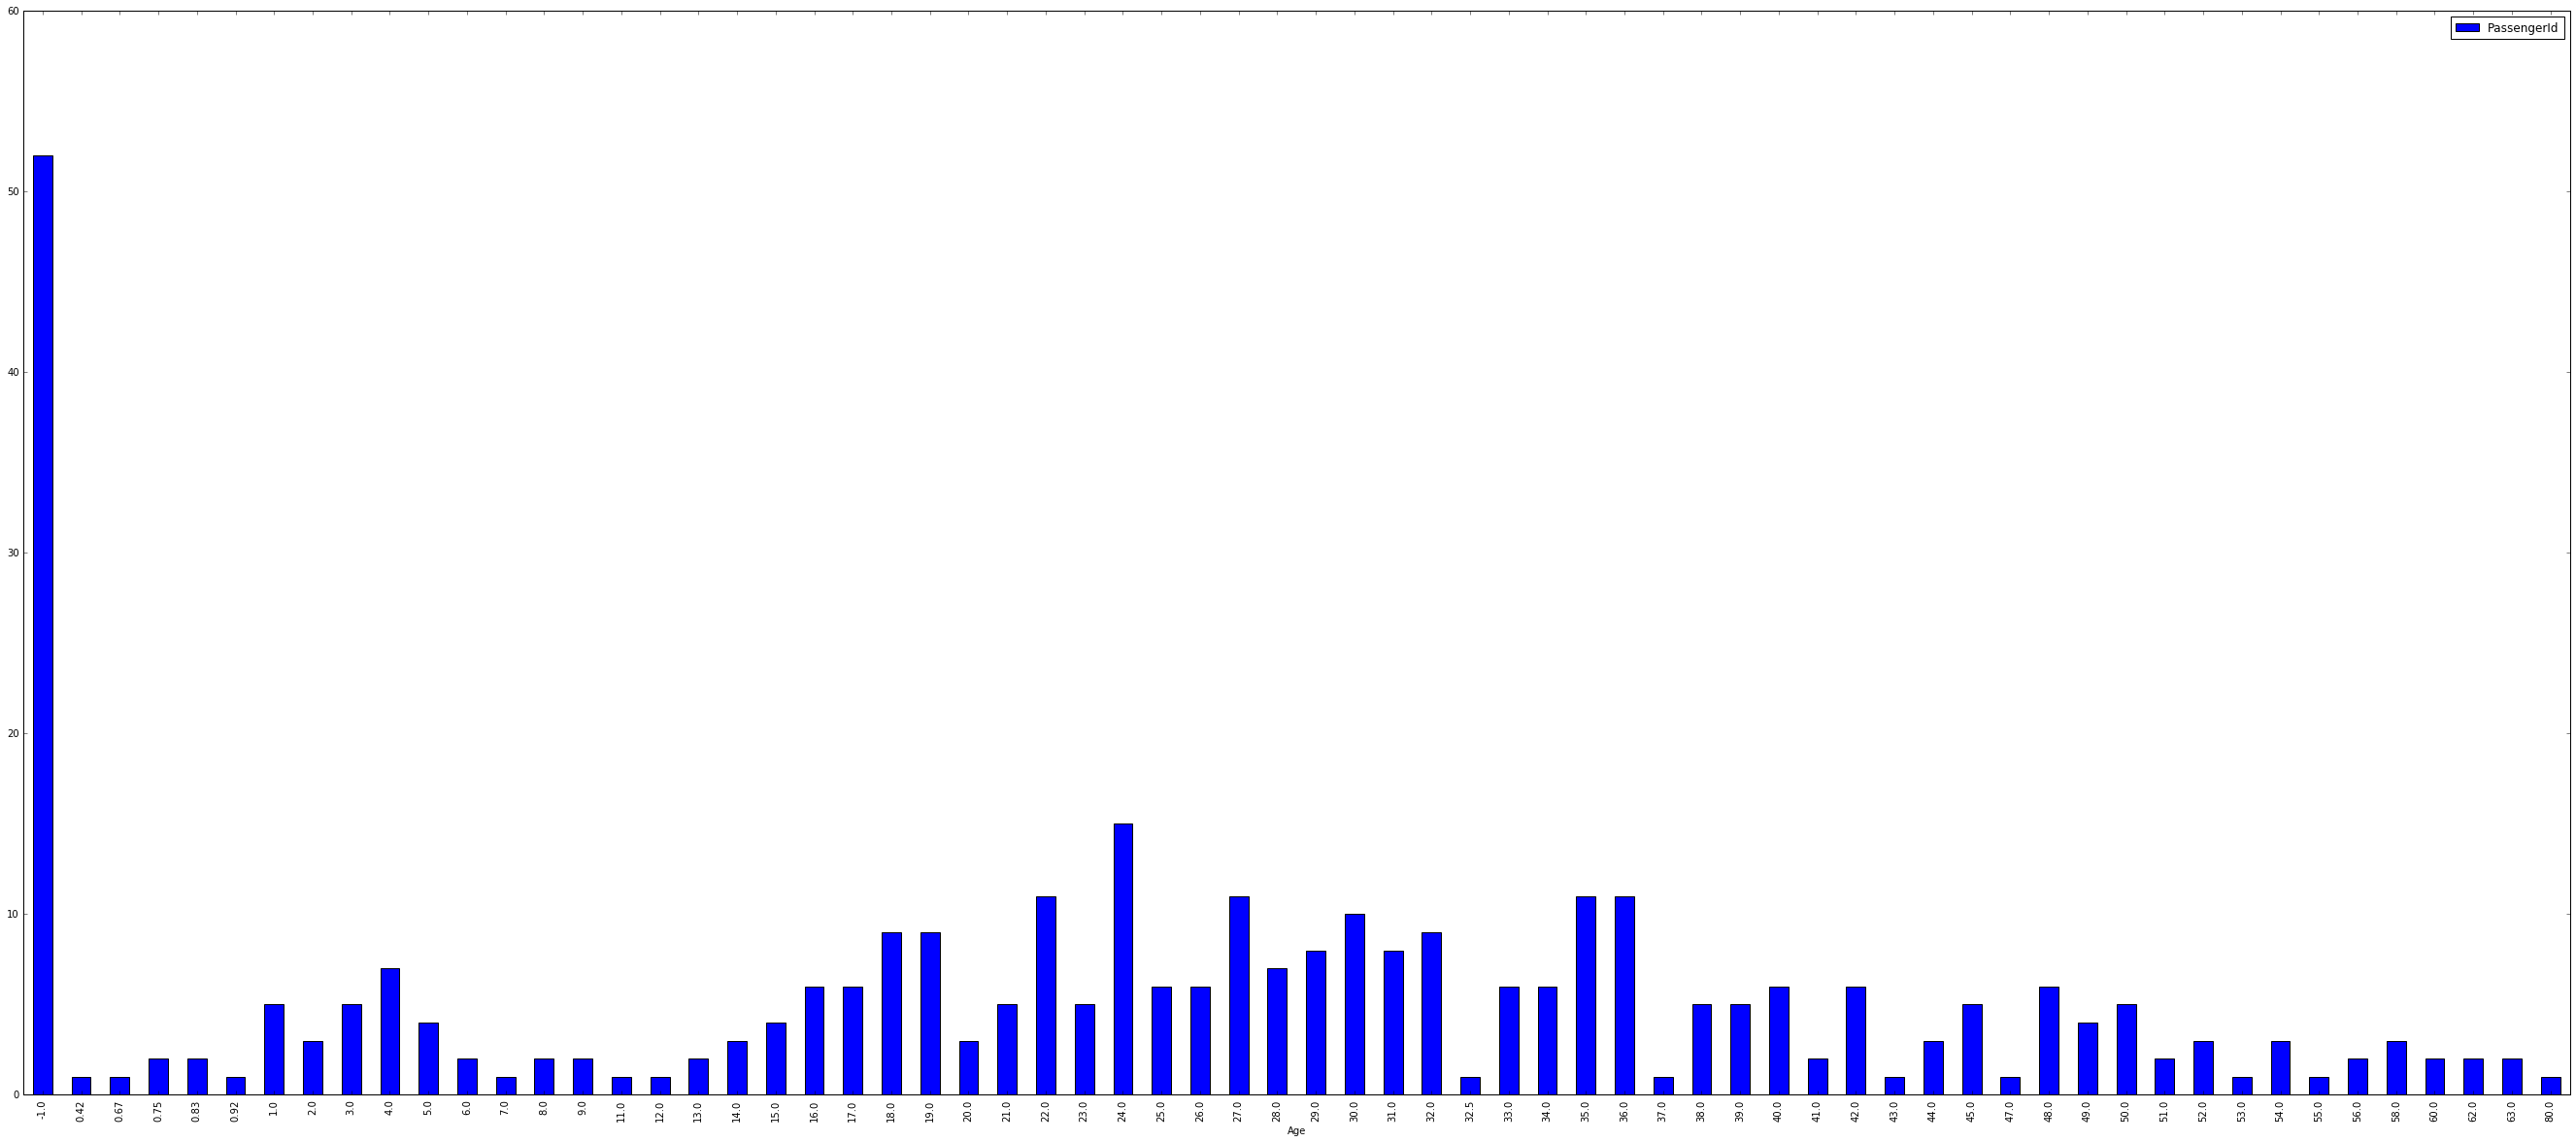

In [41]:
clean_data[clean_data['Survived'] == 1].groupby('Age').count().reset_index().plot(kind='bar',y='PassengerId', x='Age')
#pd.pivot_table(clean_data[clean_data['Survived'] == 1], index='Age', aggfunc=np.count_nonzero

But this is not very helpful, since we don't see how many people there was in each group. We can either represent both survivors or not, or calculate a ratio by age.

Let's see which helps us more.

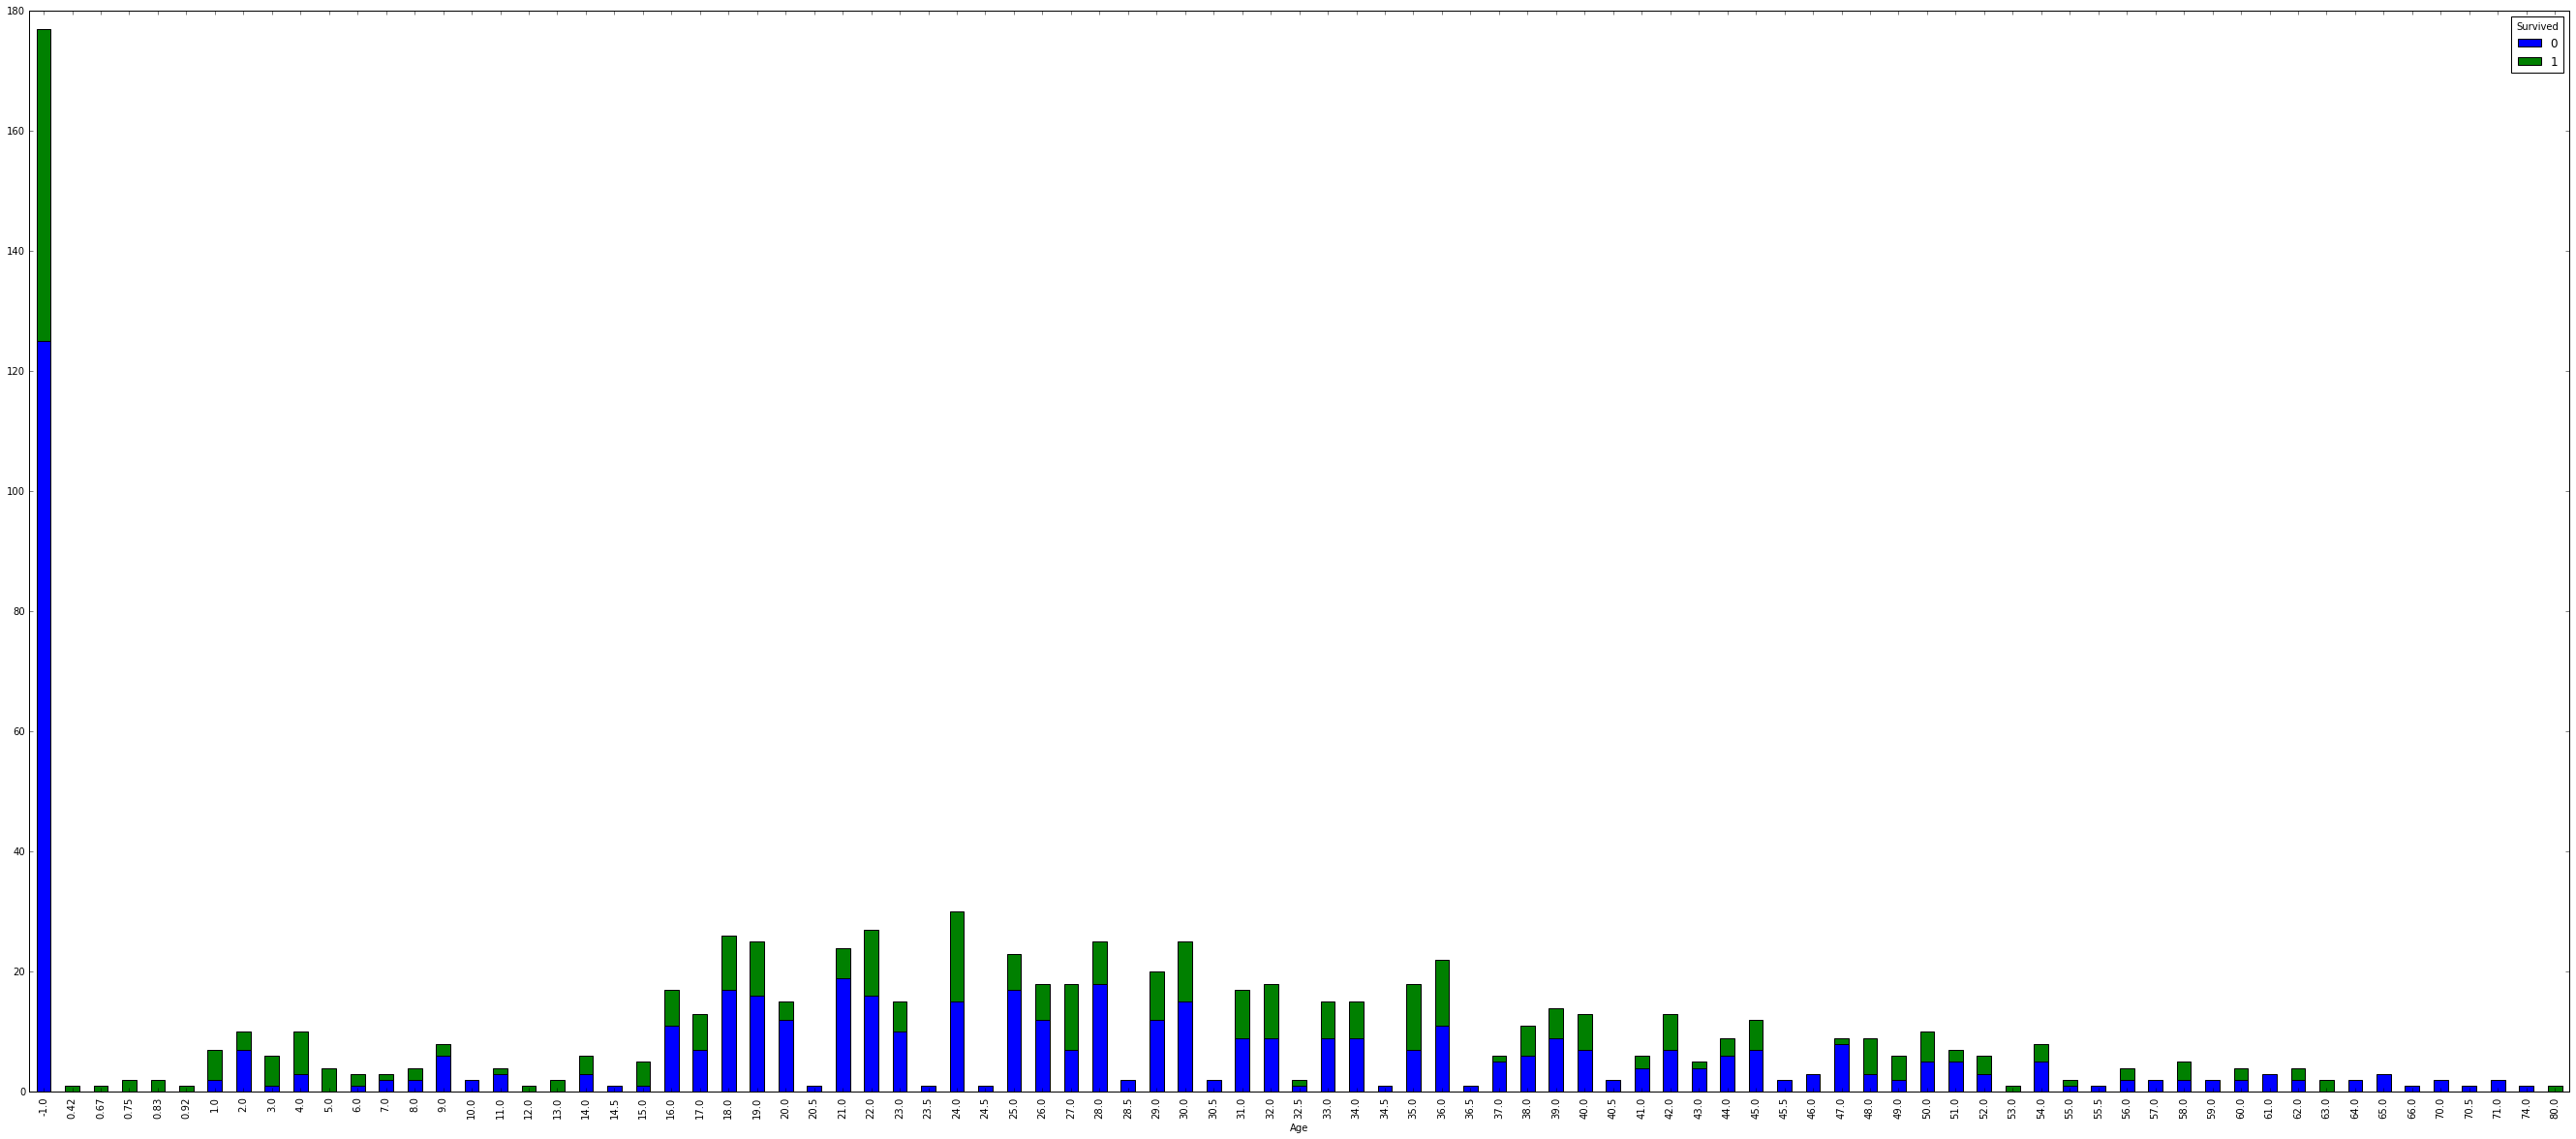

In [84]:
#clean_data.groupby(['Age','Survived']).count().reset_index().plot(kind='bar',stacked = True, y='PassengerId', x='Age')
pivot_age = pd.pivot_table(clean_data, values='PassengerId', index='Age', columns='Survived', aggfunc=np.count_nonzero)
pivot_age.fillna(0).plot(kind='bar', stacked='True')

From what we can see, not much information can be gained from age, but let's analyse by ratio, to be certain about that.

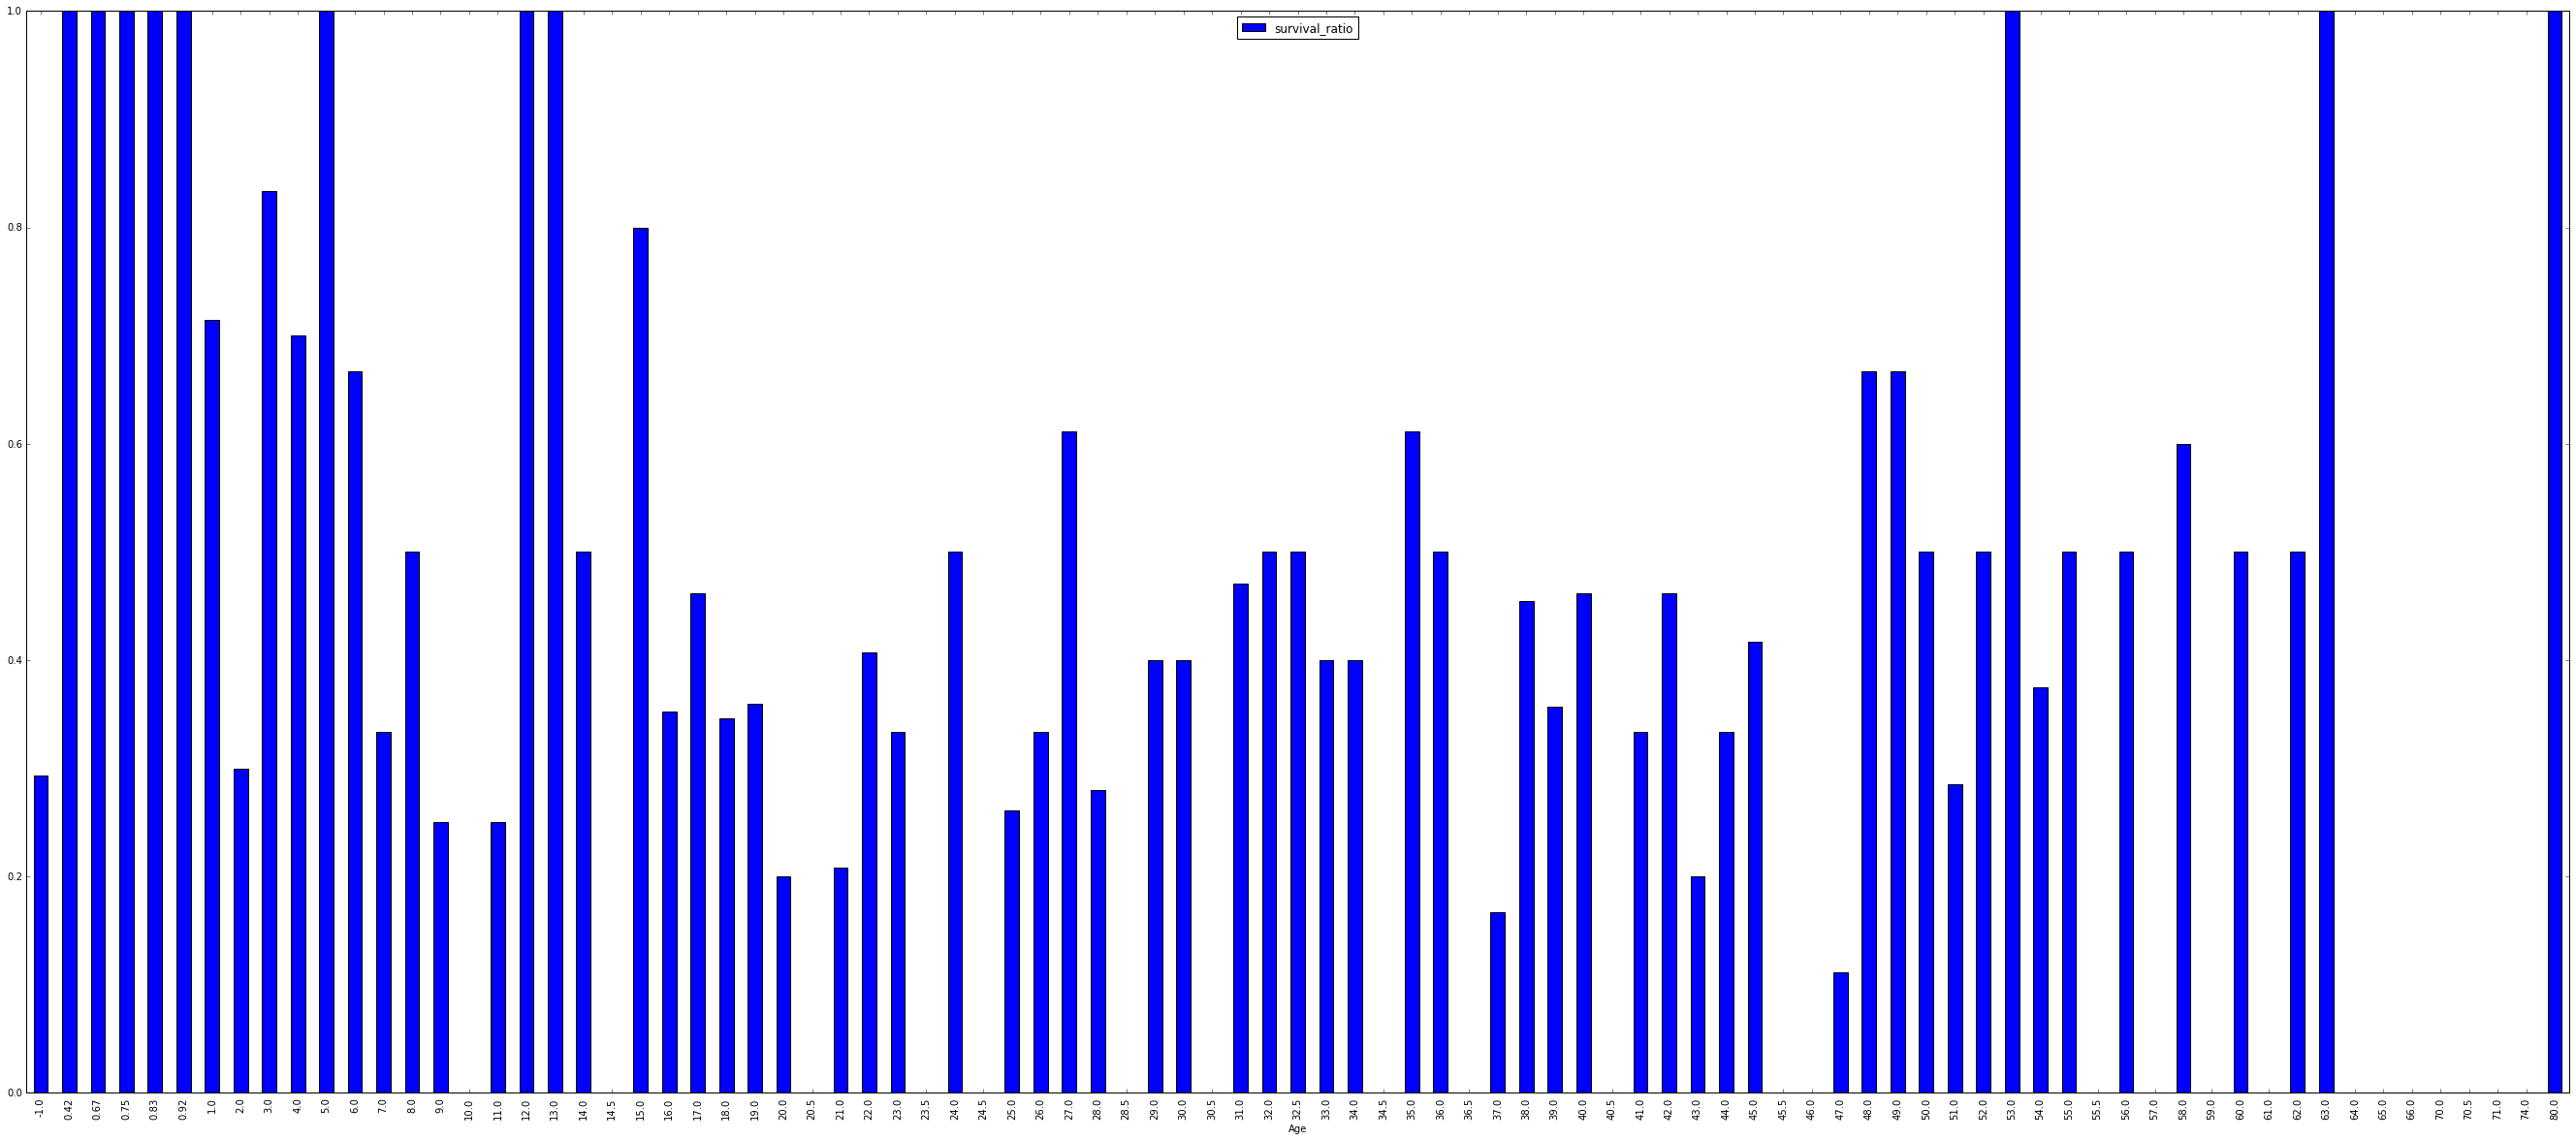

In [94]:
pivot_age = pivot_age.fillna(0)
pivot_age['survival_ratio'] = pivot_age[1] / (pivot_age[0] + pivot_age[1])
pivot_age.plot(kind = 'bar', y='survival_ratio')

From this plot we can extract that the higher ratios of survival are up to 9 years, and between 11 and 14. Some other interesting ranges of age have good survival rates, like from 47 to 55.

### Survival by Sex
Let's see which sex survived more.
#### Code

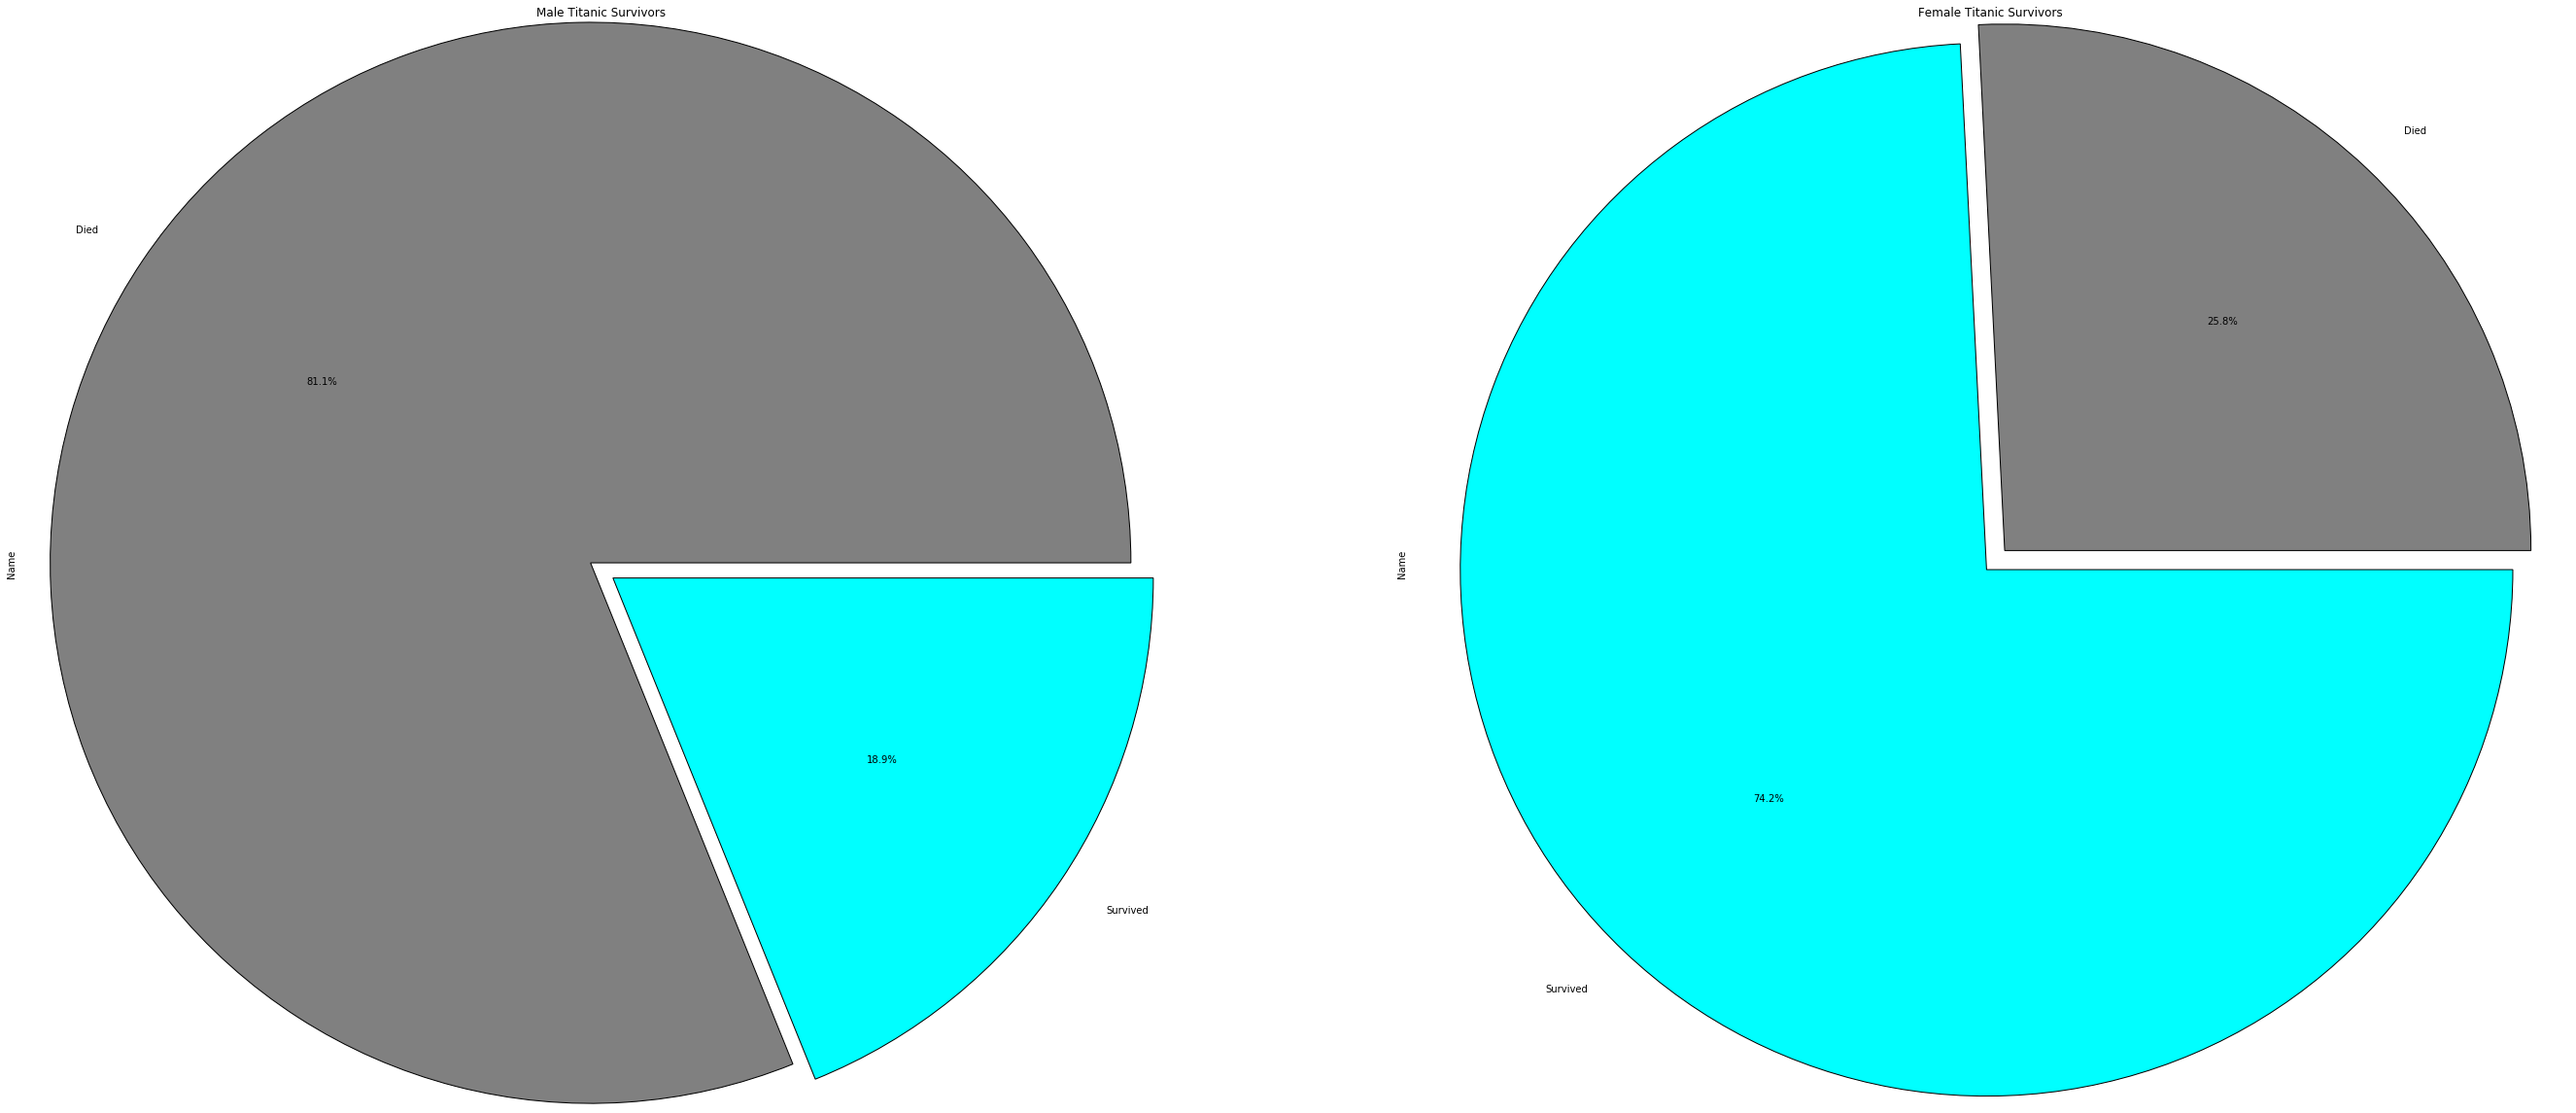

In [99]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2)
survivors_male = clean_data[clean_data['Sex']=='male'].groupby('Survived').count()['Name']
survivors_female = clean_data[clean_data['Sex']=='female'].groupby('Survived').count()['Name']

#plt.figure(figsize=(18,8))
#cmap = plt.cm.hsv
colors = ['grey','cyan']
male_plot = survivors_male.plot(kind='pie', labels=['Died','Survived'], explode=[0,0.05], autopct='%1.1f%%', colors = colors, ax=axes[0])

male_plot.axis("equal")
male_plot.set_title("Male Titanic Survivors")
#plt.show();

plt.figure(figsize=(18,8))
cmap = plt.cm.hsv
colors = ['grey','cyan']
female_plot = survivors_female.plot(kind='pie', labels=['Died','Survived'], explode=[0,0.05], autopct='%1.1f%%', colors = colors, ax=axes[1])

female_plot.axis("equal")
female_plot.set_title("Female Titanic Survivors")
#plt.show();

#df1.plot(ax=axes[0,0])
#df2.plot(ax=axes[0,1])

As we can clearly see with this representation, we have a lot of females surviving. Around a 75 %.
m
Only with this information we could already have a pre


Pending
Survival by age and sex
Survival by age and class
Survival by sex and class